## Imports

In [1]:
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen

/home/jsulpico/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/jsulpico/.local/lib/python2.7/site-packages/pandas/core/nanops.py:39: UserWarning: The installed version of bottleneck 0.7.0 is not supported in pandas and will be not be used
The minimum supported version is 1.0.0

  ver=ver, min_ver=_MIN_BOTTLENECK_VERSION), UserWarning)


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [2]:
import os
import librosa as lr
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

## Constants

## Helpers

In [3]:
def nsynth_encode(wav_path):
    # Checkpoint path
    checkpoint_path = './wavenet-ckpt/model.ckpt-200000'
    
    # Load Audio
    sr = 16000
    audio, _ = lr.load(wav_path, sr=sr)
    
    # Encode
    encoding = fastgen.encode(audio, checkpoint_path, audio.shape[0])
    
    return encoding.reshape((-1, 16))

In [4]:
def get_scaled_umap_embeddings(features, neighbor, distance):
    embedding = umap.UMAP(n_neighbors=neighbor,
                          min_dist=distance,
                          metric='correlation').fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

In [5]:
def get_scaled_tsne_embeddings(features, perplexity, iteration):
    embedding = TSNE(n_components=2,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

In [6]:
def transform_numpy_to_json(array):
    data = []
    for position in array:
        data.append({
            'coordinates': position.tolist()
        })
    return data

## Wrangle Data

In [7]:
# Subset of MAPs
DATASET_DIR = '../datasets/maps/AkPnBcht/ISOL/'

In [8]:
wav_paths = []
for subdir_name in os.listdir(DATASET_DIR):
    subdir_path = os.path.join(DATASET_DIR, subdir_name)
    if not os.path.isdir(subdir_path):
        continue
    for dir_parent, dir_name, file_names in os.walk(subdir_path):
        for name in file_names:
            if name.endswith('.wav'):
                wav_paths.append(os.path.join(dir_parent, name))

In [9]:
np.random.shuffle(wav_paths)
print len(wav_paths)

735


In [10]:
sample_wav_paths = wav_paths[:100]

## NSynth Encode and Apply MFCCs

The difference in lengths between NSynth Encodings and MFCCs means we have to compress said variable features into a set vector of numbers for plotting. So the feature vector is comprised of:
- Mean (compute mean for each dimension in feature. MFCCs - 13, NSynth - 16)
- STD (of each dimension)
- Mean First Order (difference between successive frames, how much on average are the features changing)

The result is for any variable length NSynth Encoding or MFCC, they get squashed into a vector of 39 numbers for MFCCs or 48 numbers for NSynth.

Reference:
https://medium.com/@LeonFedden/comparative-audio-analysis-with-wavenet-mfccs-umap-t-sne-and-pca-cb8237bfce2f

In [11]:
dataset = []
errors = 0

In [12]:
for path in sample_wav_paths:
    print "Processing.. " + path
    # Compile NSynth encodings
    nsynth_encoding = nsynth_encode(path)
    stddev_nsynth = np.std(nsynth_encoding, axis=0)
    mean_nsynth = np.mean(nsynth_encoding, axis=0)

    avg_diff_nsynth = np.zeros((16,))
    for i in range(0, len(nsynth_encoding) - 2, 2):
        avg_diff_nsynth += nsynth_encoding[i] - nsynth_encoding[i+1]
    avg_diff_nsynth /= (len(nsynth_encoding) // 2)
    avg_diff_nsynth = np.array(avg_diff_nsynth)

    nsynth_features = np.hstack((stddev_nsynth, mean_nsynth))
    nsynth_features = np.hstack((nsynth_features, avg_diff_nsynth))
    
    # Compile MFCCs
    mfcc_size = 13
    sample_rate = 44100
    audio, _ = lr.load(path)
    trimmed_data, _ = lr.effects.trim(y=audio)
    mfccs = lr.feature.mfcc(trimmed_data, sample_rate, n_mfcc=mfcc_size)

    stddev_mfccs = np.std(mfccs, axis=1)
    mean_mfccs = np.mean(mfccs, axis=1)

    avg_diff_mfcc = np.zeros((mfcc_size,))
    for i in range(0, len(mfccs.T) - 2, 2):
        avg_diff_mfcc += mfccs.T[i] - mfccs.T[i+1]
    avg_diff_mfcc /= (len(mfccs) // 2)
    avg_diff_mfcc = np.array(avg_diff_mfcc)

    mfcc_features = np.hstack((stddev_mfccs, mean_mfccs))
    mfcc_features = np.hstack((mfcc_features, avg_diff_mfcc))

    # Aggregate Features
    dataset += [(os.path.basename(path), nsynth_features, mfcc_features)]
        
#     except:
#         print "Error found: " + path
#         errors += 1
        
# print "Errors: " + str(errors)
    

Processing.. ../datasets/maps/AkPnBcht/ISOL/ST/MAPS_ISOL_ST_M_S0_M30_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/TR2/MAPS_ISOL_TR2_P_S0_M87_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/ST/MAPS_ISOL_ST_F_S0_M92_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/NO/MAPS_ISOL_NO_P_S1_M73_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/TR2/MAPS_ISOL_TR2_F_S0_M37_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/ST/MAPS_ISOL_ST_F_S1_M33_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/NO/MAPS_IS

INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/NO/MAPS_ISOL_NO_M_S0_M98_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/RE/MAPS_ISOL_RE_F_S1_M70_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/ST/MAPS_ISOL_ST_F_S1_M77_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/TR1/MAPS_ISOL_TR1_F_S1_M98_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/ST/MAPS_ISOL_ST_P_S1_M24_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
Processing.. ../datasets/maps/AkPnBcht/ISOL/ST/MAPS_ISOL_ST_F_S1_M48_AkPnBcht.wav
INFO:tensorflow:Restoring parameters from ./wavenet-ckpt

In [13]:
# Prep for plots
all_file_paths, nsynth_features, mfcc_features = zip(*dataset)
nsynth_features = np.nan_to_num(np.array(nsynth_features))
mfcc_features = np.nan_to_num(np.array(mfcc_features))

nsynth_tuples = []
mfcc_tuples = []

all_json = dict()
all_json["filenames"] = all_file_paths
print len(all_file_paths), nsynth_features.shape, mfcc_features.shape

100 (100, 48) (100, 39)


## Make UMAP Embeddings
According to the reference, Uniform Manifold Approximation and Projection (UMAP) had the most promising plots for their given set of data. 

In [14]:
umap_embeddings_mfccs = []
umap_embeddings_nsynth = []
neighbors = [5, 10, 15, 30, 50]
distances = [0.000, 0.001, 0.01, 0.1, 0.5]
iterations = [200, 500, 1000, 2000, 5000]
for i, neighbor in enumerate(neighbors):
    for j, distance in enumerate(distances):
        umap_mfccs = get_scaled_umap_embeddings(mfcc_features,
                                                neighbor,
                                                distance)
        umap_nsynth = get_scaled_umap_embeddings(nsynth_features,
                                                 neighbor,
                                                 distance)
        umap_embeddings_mfccs.append(umap_mfccs)
        umap_embeddings_nsynth.append(umap_nsynth)
        
        mfcc_key = 'umapmfcc{}{}'.format(i, j)
        nsynth_key = 'umapnsynth{}{}'.format(i, j)
        
        all_json[mfcc_key] = transform_numpy_to_json(umap_mfccs)
        all_json[nsynth_key] = transform_numpy_to_json(umap_nsynth)

print len(umap_embeddings_mfccs)
print len(umap_embeddings_nsynth)

25
25


## UMap Plots

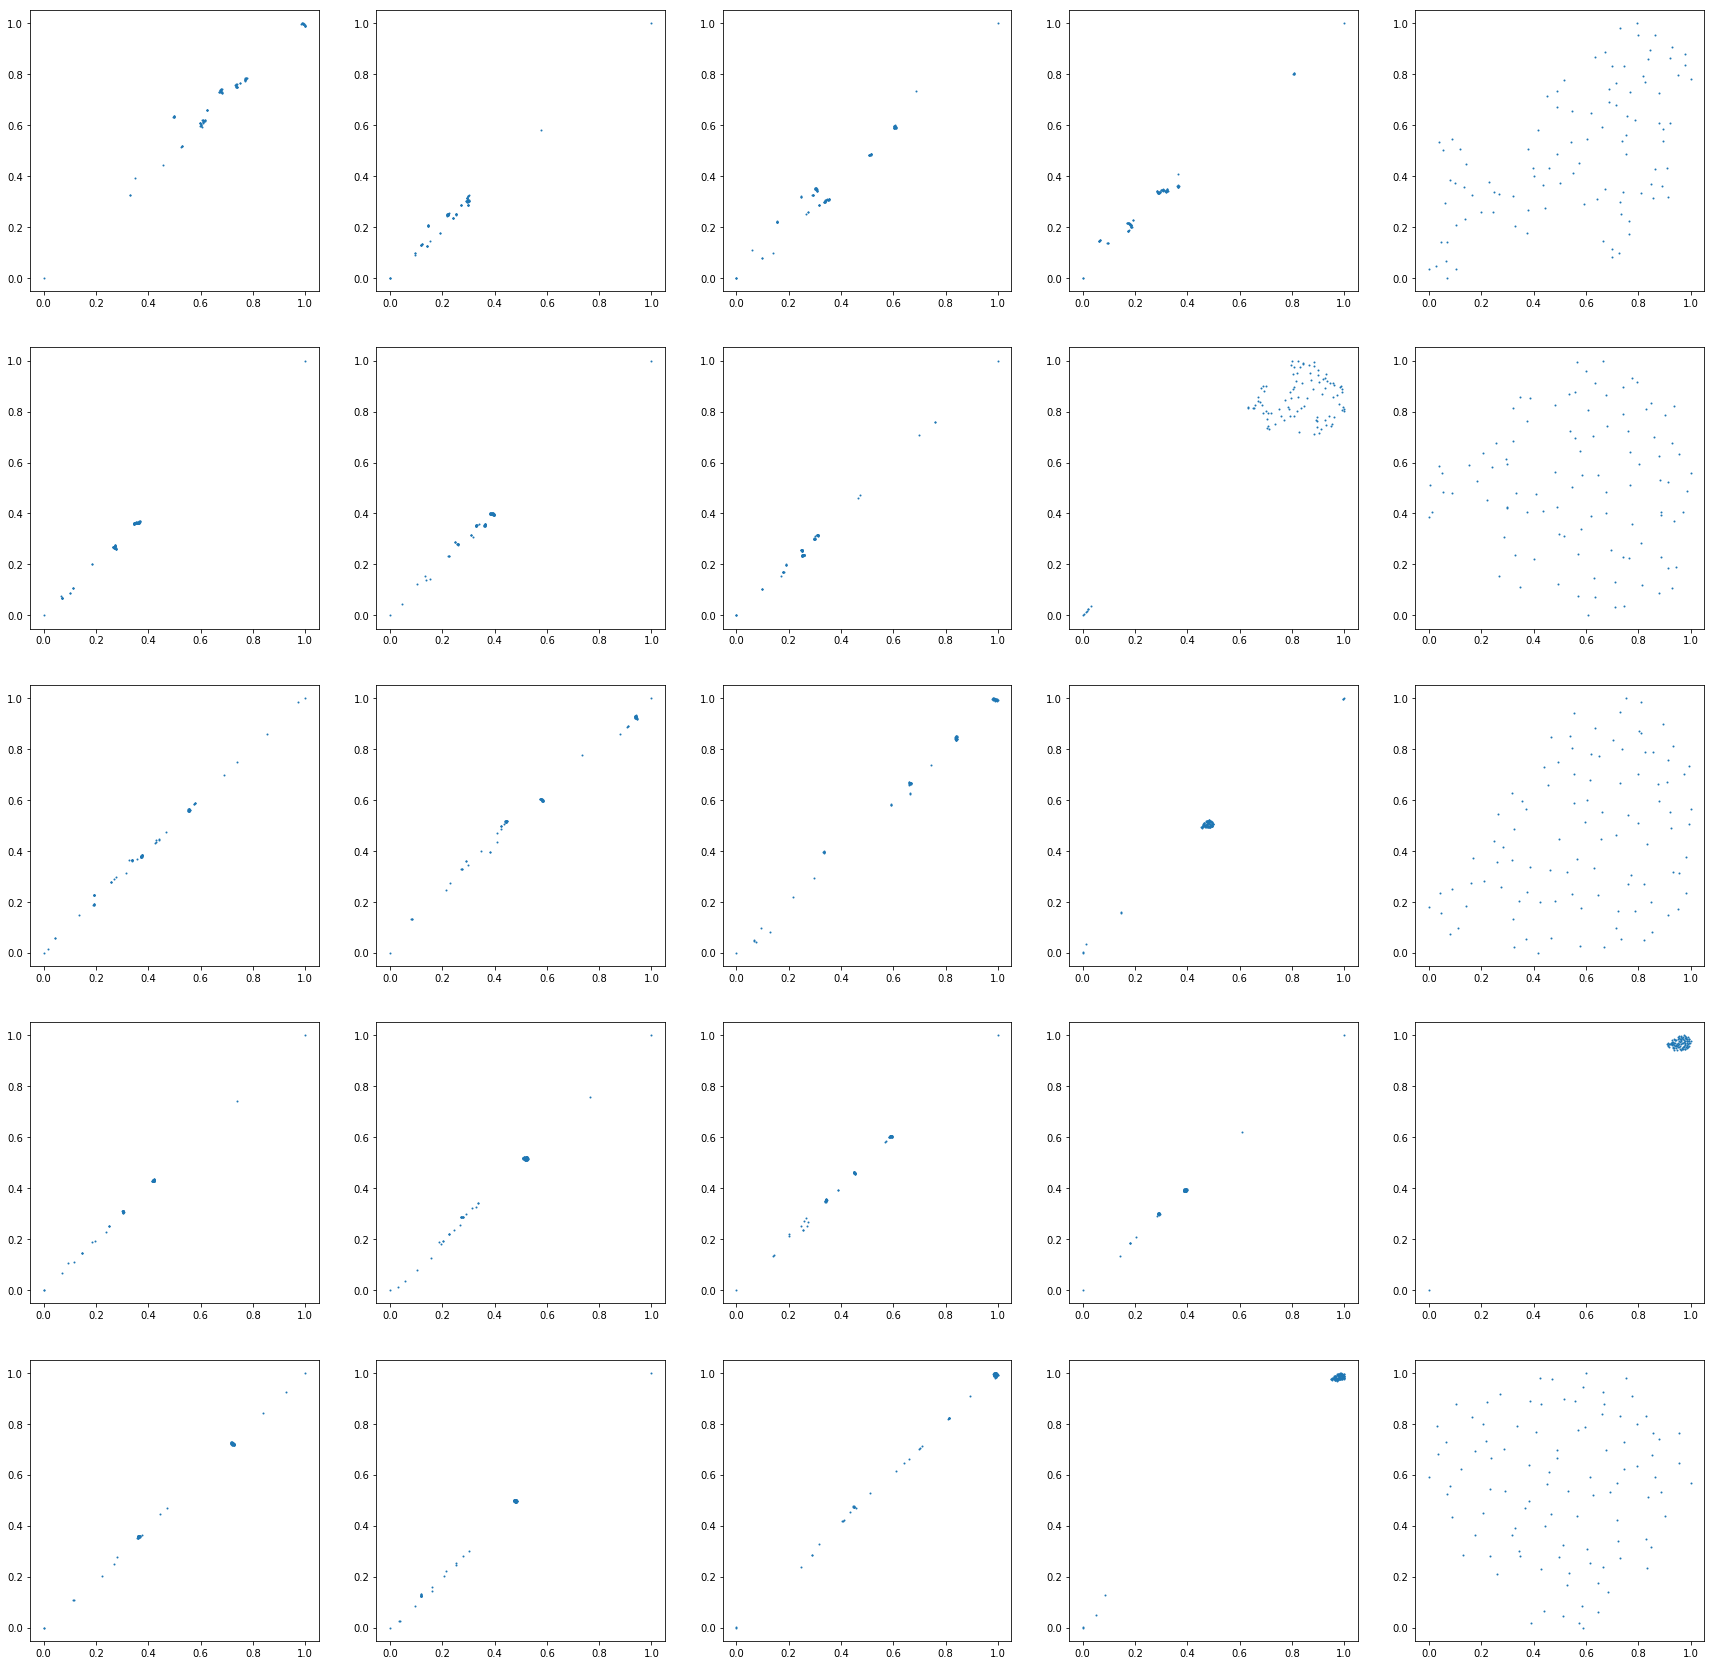

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot MFCCs
fig, ax = plt.subplots(nrows=len(neighbors),
                       ncols=len(distances),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        cur_plot = i * len(iterations) + j
        col.scatter(umap_embeddings_mfccs[cur_plot].T[0],
                    umap_embeddings_mfccs[cur_plot].T[1],
                    s=1)

plt.savefig("umap_mfccs")
plt.show()
plt.clf()

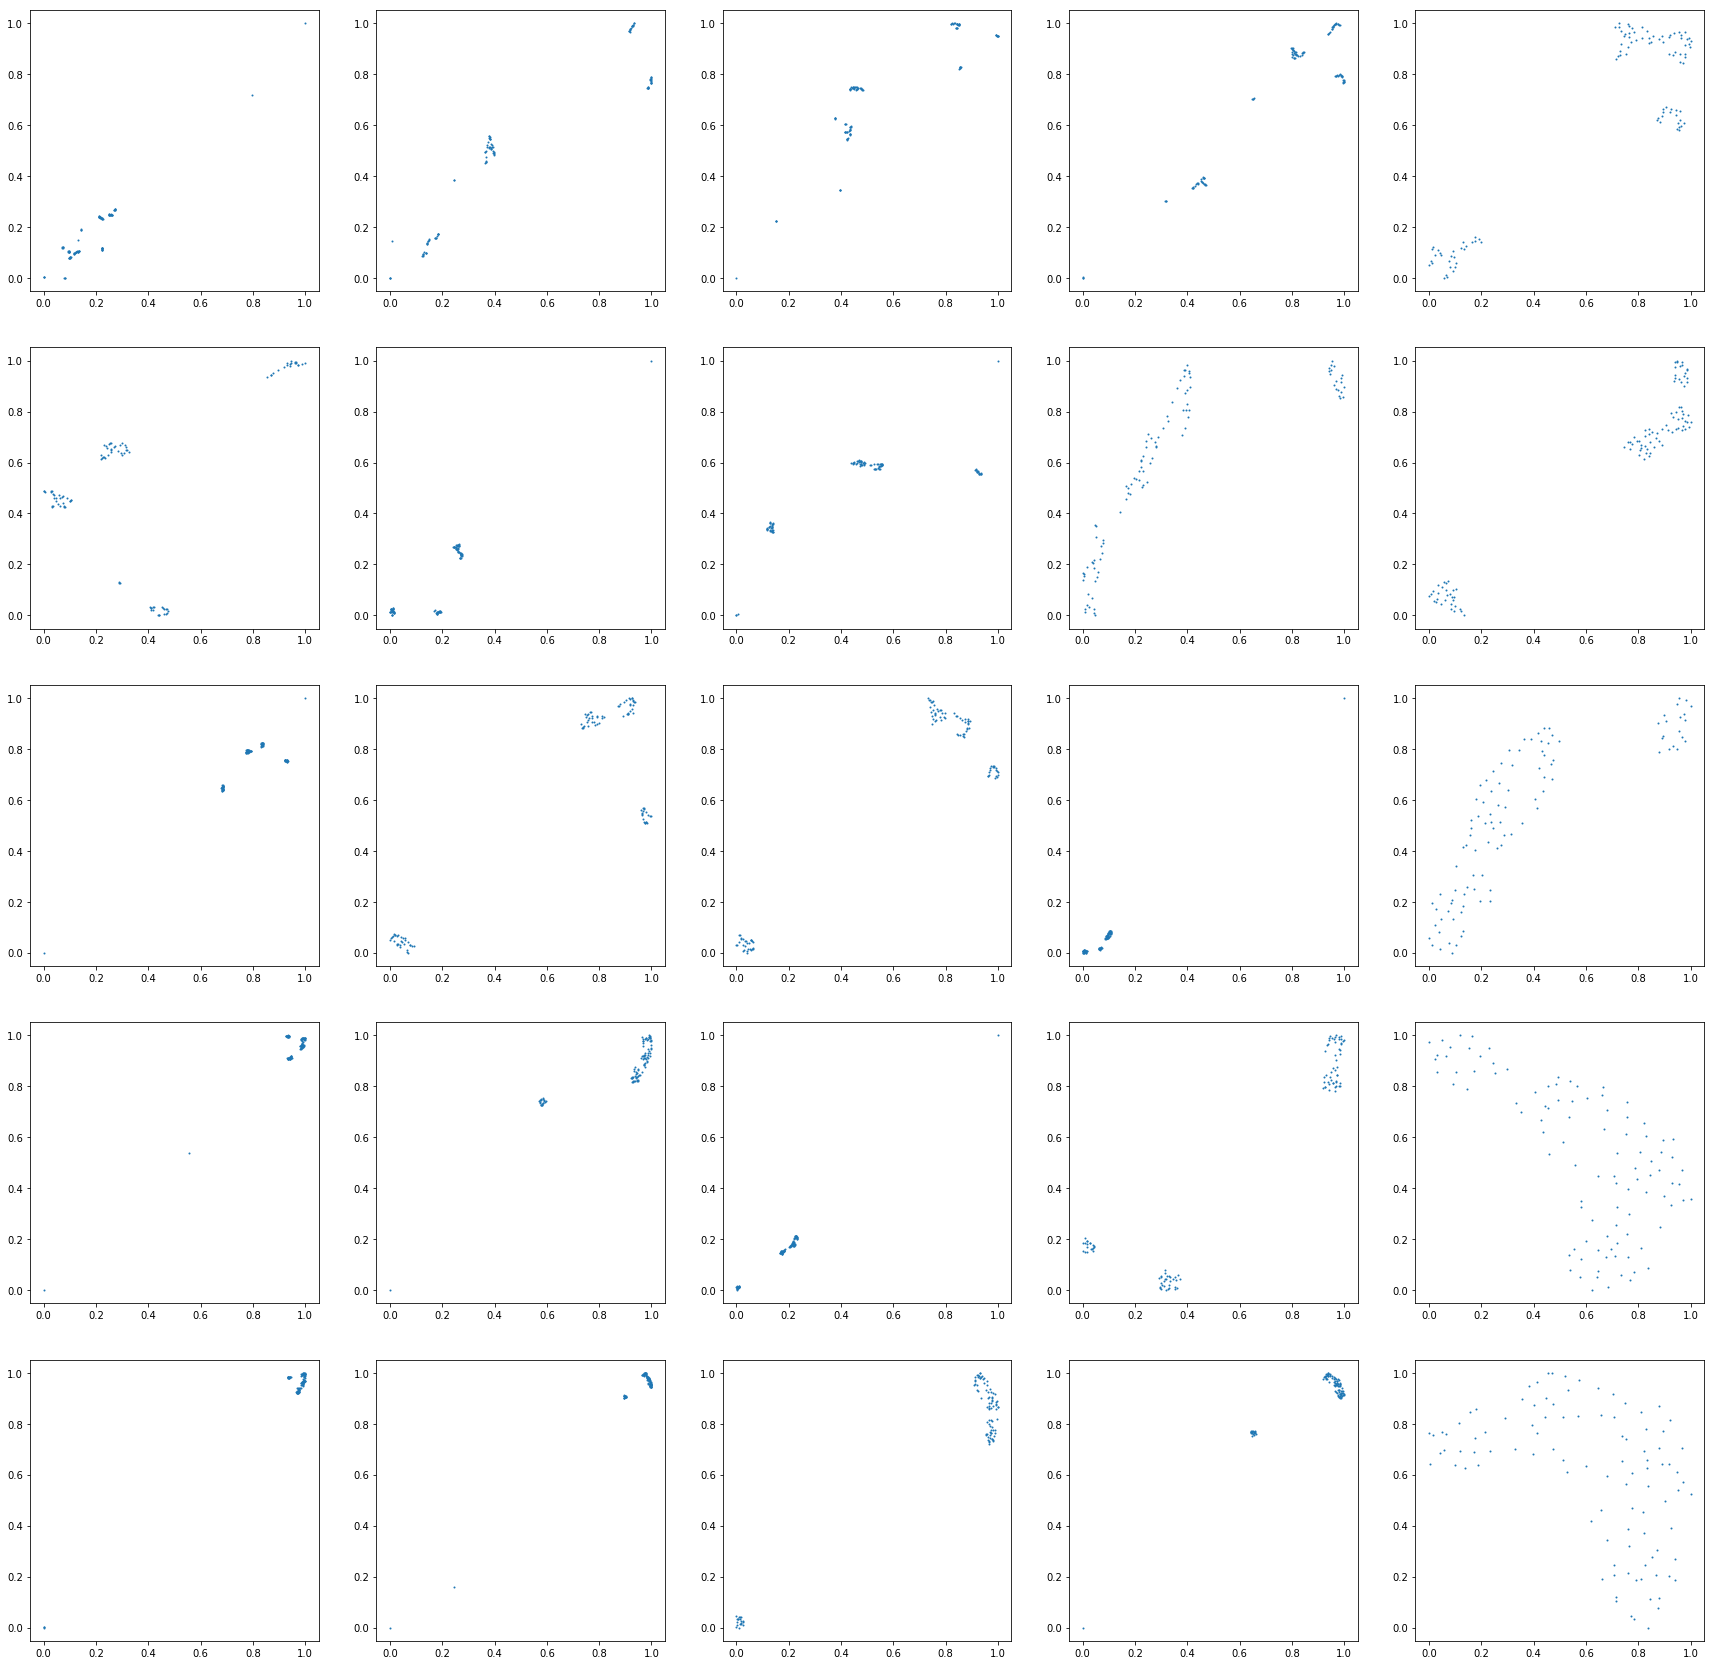

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot NSynths
fig, ax = plt.subplots(nrows=len(neighbors),
                       ncols=len(distances),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        cur_plot = i * len(iterations) + j
        col.scatter(umap_embeddings_nsynth[cur_plot].T[0],
                    umap_embeddings_nsynth[cur_plot].T[1],
                    s=1)

plt.savefig("umap_nsynths")
plt.show()
plt.clf()



## Make t-SNE Embeddings

In [21]:
tsne_embeddings_mfccs = []
tsne_embeddings_nsynth = []
perplexities = [2, 5, 30, 50, 100]
iterations = [250, 500, 1000, 2000, 5000]
for i, perplexity in enumerate(perplexities):
    for j, iteration in enumerate(iterations):
        tsne_mfccs = get_scaled_tsne_embeddings(mfcc_features,
                                                perplexity,
                                                iteration)
        tsne_nsynth = get_scaled_tsne_embeddings(nsynth_features,
                                                  perplexity,
                                                  iteration)
        tsne_embeddings_mfccs.append(tsne_mfccs)
        tsne_embeddings_nsynth.append(tsne_nsynth)
        
        mfcc_key = 'tsnemfcc{}{}'.format(i, j) 
        wavenet_key = 'tsnensynth{}{}'.format(i, j) 
        
        all_json[mfcc_key] = transform_numpy_to_json(tsne_mfccs)
        all_json[wavenet_key] = transform_numpy_to_json(tsne_nsynth)

## t-SNE Plots

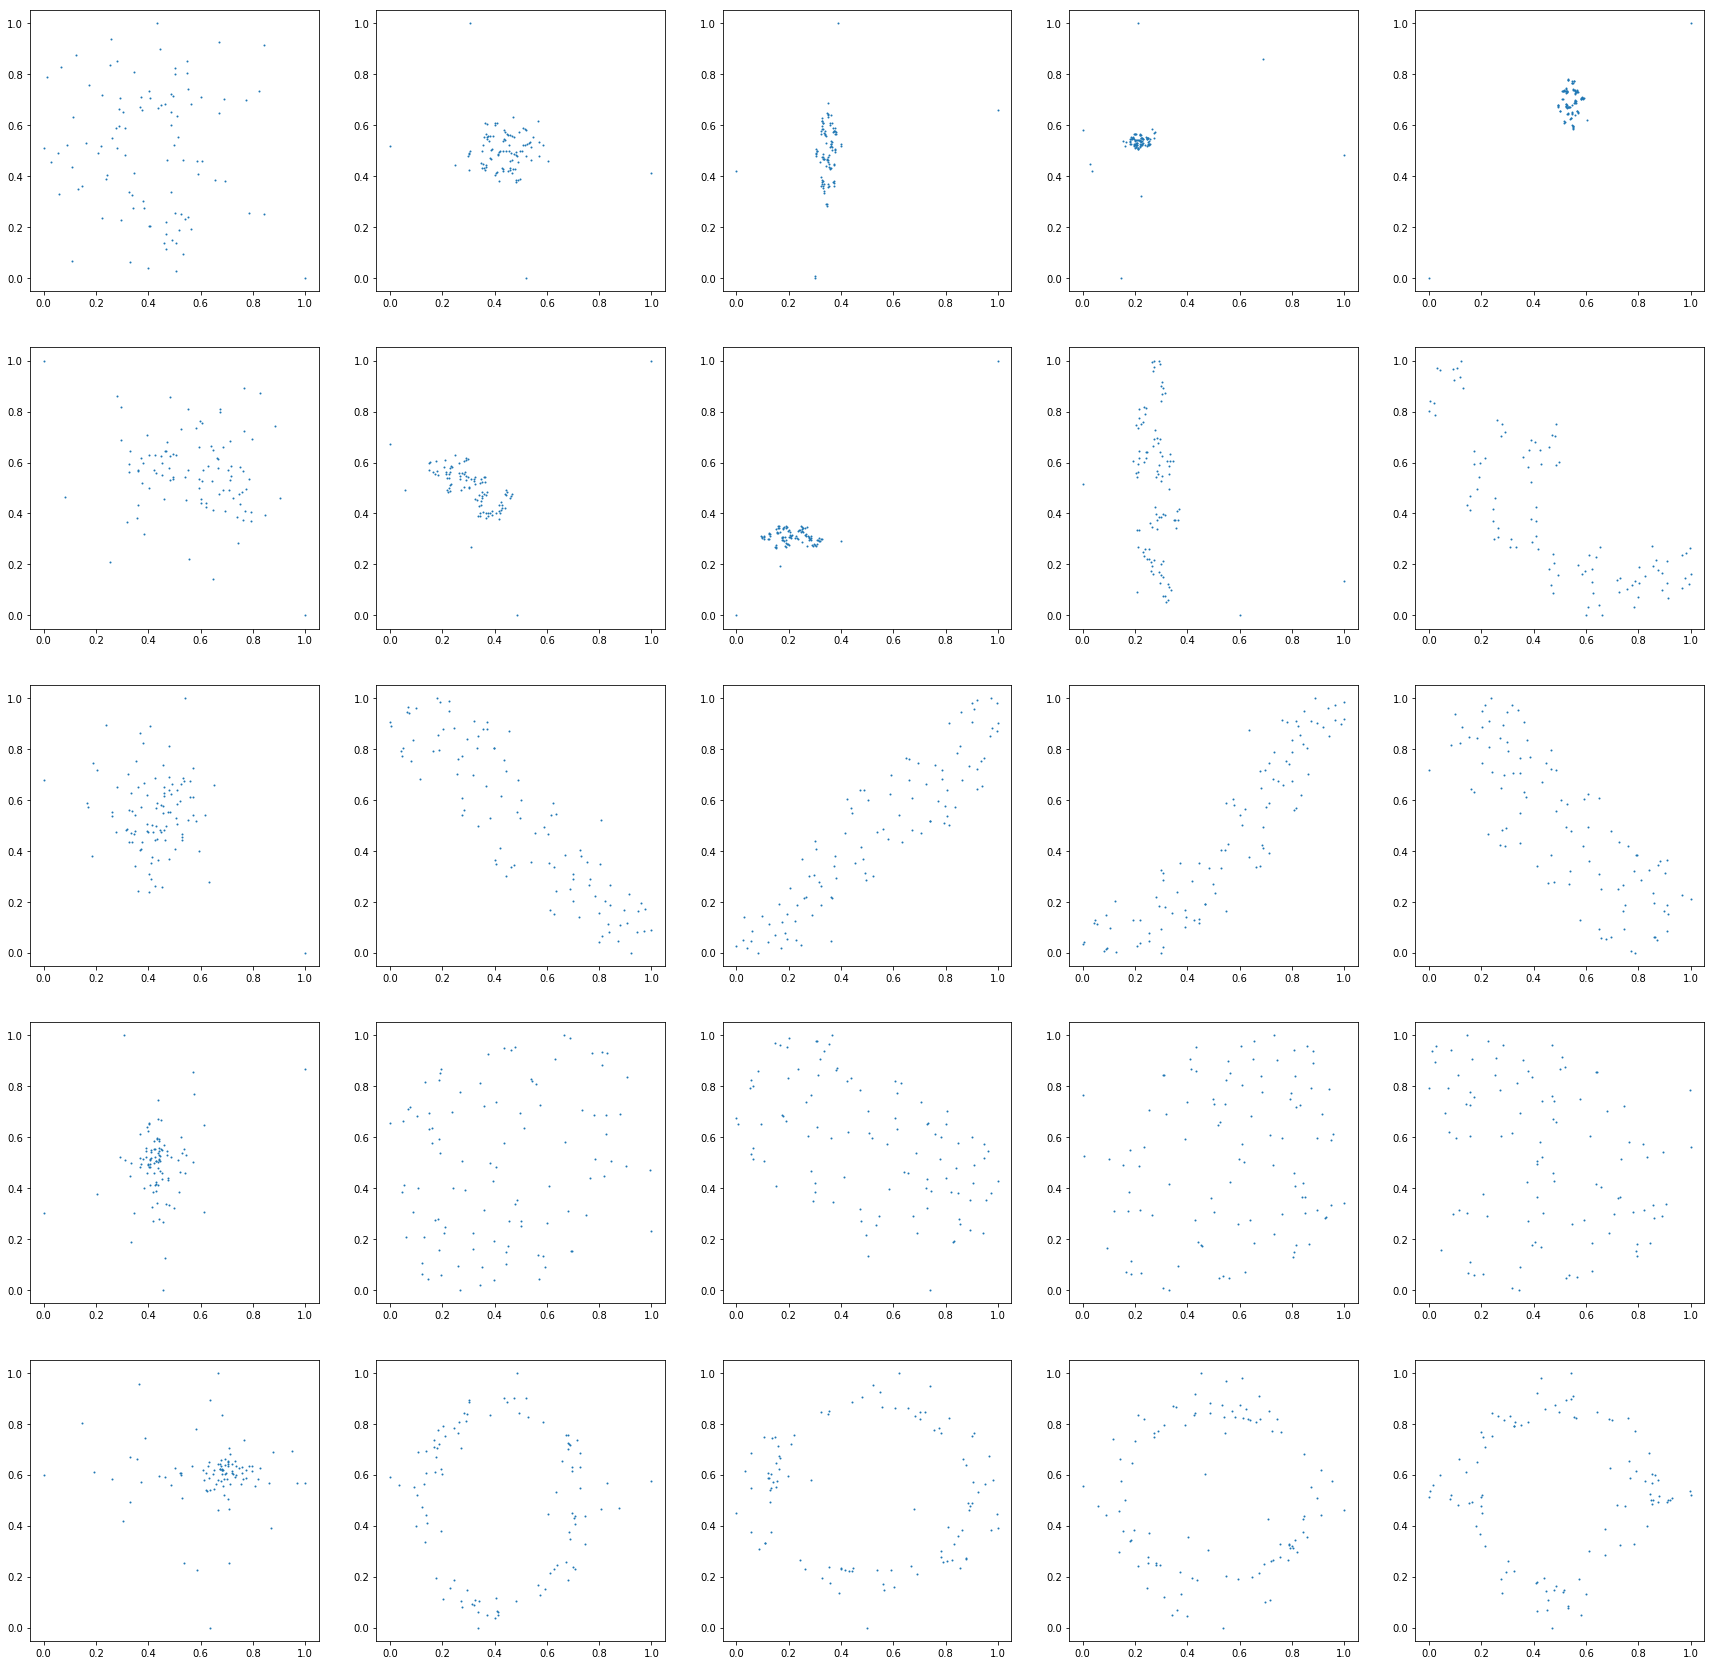

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot MFCCs
fig, ax = plt.subplots(nrows=len(perplexities),
                       ncols=len(distances),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        cur_plot = i * len(iterations) + j
        col.scatter(tsne_embeddings_mfccs[cur_plot].T[0],
                    tsne_embeddings_mfccs[cur_plot].T[1],
                    s=1)

plt.savefig("tsne_mfccs")
plt.show()
plt.clf()

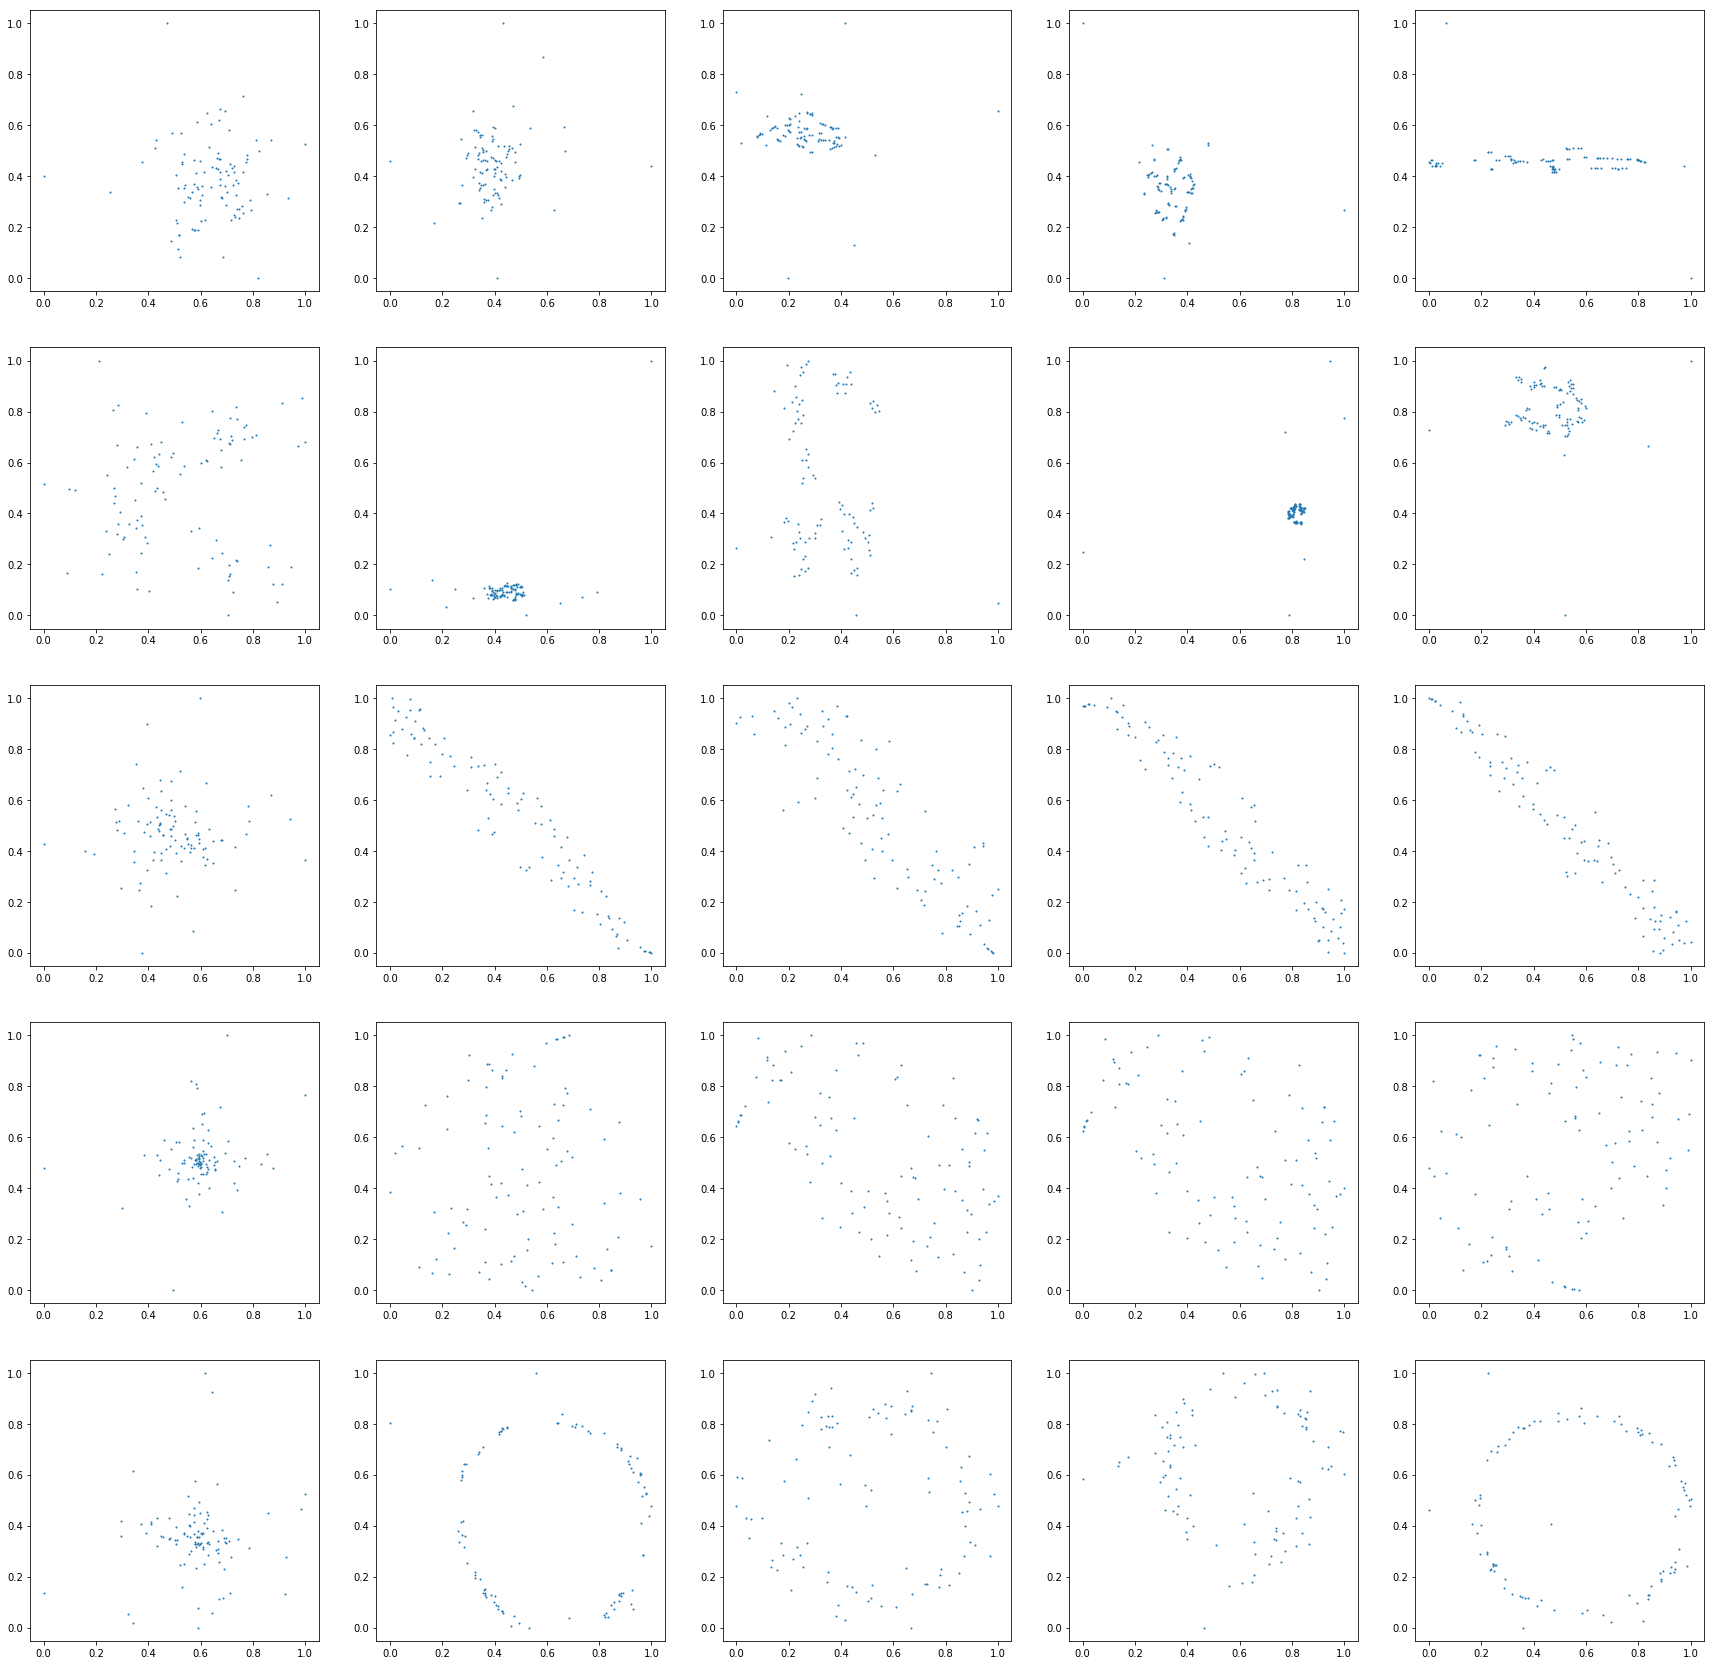

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot NSynths
fig, ax = plt.subplots(nrows=len(perplexities),
                       ncols=len(distances),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        cur_plot = i * len(iterations) + j
        col.scatter(tsne_embeddings_nsynth[cur_plot].T[0],
                    tsne_embeddings_nsynth[cur_plot].T[1],
                    s=1)

plt.savefig("tsne_nsynth")
plt.show()
plt.clf()